In [1]:
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import mglearn

### 3.5.4 聚类算法的对比与评估
在应用聚类算法时，其挑战之一就是很难评估一个算法的效果好坏，也很难比较不同算法的结果。我们使用一些现实世界的数据集上比较一下kMeans、DBSCAN和凝聚聚类算法。

[注：A demo of K-Means clustering on the handwritten digits data](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)

#### 3.5.4.1 用真实值评估聚类
有一些指标可用于评估聚类算法相对于真实聚类的结果，其中最重要的是`调整rand指数`(adjusted rand index，ARI)和归一化互信息(normalized mutual information，NMI)，二者都给出了定量的度量，其最佳值为1，0表示不相关的聚类(虽然ARI可以取负值)。

下面我们使用ARI来比较kMeans、DBSCAN和凝聚聚类算法。为了对比，我们还添加了将点随机分配到两个簇中的图像(见`图3-39`)。

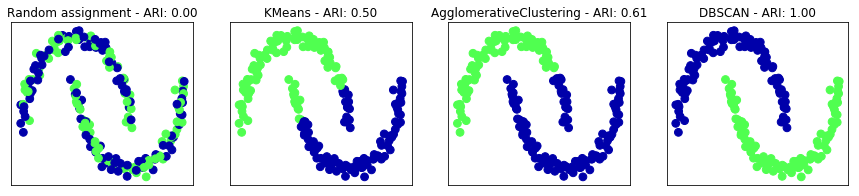

In [2]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 将数据缩放成平均值为0、方差为1
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'xticks':(), 'yticks':()})

# 列出要使用的算法
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

# 创建一个随机的簇分配，作为参考
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# 绘制随机分配
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # 绘制簇分配和簇中心
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(y, clusters)))

plt.show()

`调整rand指数`给出了符合直觉的结果，随机簇分配的分数为0，而DBSCAN的分数为1。

用这种方式评估聚类时，一个常见的错误是使用`accuracy_score`而不是`adjusted_rand_score`、`normalized_mutual_info_score`或其他聚类指标。使用精度的问题在于，它要求分配的簇标签与真实值完全匹配。但簇标签本身毫无意义——唯一重要的是哪些点位于同一个簇中。

In [3]:
# 这两种点标签对应于相同的聚类
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# 精度为0，因为二者标签完全不同
print("Accuracy: {:.2f}".format(accuracy_score(clusters1, clusters2)))
# 调整rand分数为1，因为二者聚类完全相同
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

Accuracy: 0.00
ARI: 1.00


#### 3.4.5.2 在没有真实值的情况下评估聚类
在实践中，使用诸如`ARI`之类的指标有一个很大的问题。在应用聚类算法时，通常没有真实值来比较结果。如果我们知道了数据的正确聚类，那么可以使用这一信息构建一个监督模型。因此，使用类似`ARI`和`NMI`的指标通常仅有助于开发算法，但对评估应用是否成功没有帮助。

有一些聚类的评分指标不需要真实值，比如`轮廓系数`(silhouette coeffcient)。但它们在实践中的效果并不好。轮廓分数计算一个簇的紧致度，其值越大越好，最高分数为1。虽然紧致的簇很好，但紧致度不允许复杂的形状。

下面的例子利用轮廓分数在`two_moons数据集`上比较kMeans、DBSCAN和凝聚聚类(`图3-40`)：

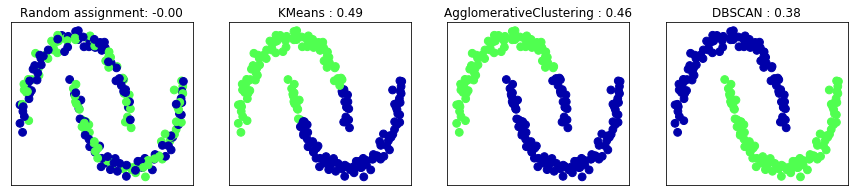

In [4]:
from sklearn.metrics.cluster import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import mglearn

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 将数据缩放成平均值为0、方差为1
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'xticks':(), 'yticks':()})

# 创建一个随机的簇分配，作为参考
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# 绘制随机分配
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # 绘制簇分配和簇中心
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__, silhouette_score(X_scaled, clusters)))
plt.show()

kMeans的轮廓分数最高，尽管我们可能更喜欢DBSCAN的结果。

对于评估聚类，稍好的策略是使用基于鲁棒性的(robustness-based)聚类指标。这种指标先向数据中添加一些噪声，或者使用不同的参数设定，然后运行算法，并对结果进行比较。其思想是，如果许多算法参数和许多数据扰动返回相同的结果，那么它很可能是可信的。不幸的是，在写作本书时，`scikit-learn`还没有实现这一策略。

**即使我们得到一个鲁棒性很好的聚类或者非常高的轮廓分数，但仍然不知道聚类中是否有任何语义含义，或者聚类是否反映了数据中我们感兴趣的某个方面。我们回到人脸图像的例子。我们希望找到类似人脸的分组，比如男人和女人、老人和年轻人，或者有胡子的人和没胡子的人。假设我们将数据分为两个簇，关于哪些点应该被聚类在一起，所有算法的结果一致。我们仍不知道找到的簇是否以某种方式对应于我们感兴趣的概念。算法找到的可能是侧视图和正面视图、夜间拍摄的照片和白天拍摄的照片，或者iPhone拍摄的照片和安卓手机拍摄的照片。要想知道聚类是否对应于我们感兴趣的内容，唯一的办法就是对簇进行人工分析。**

#### 3.4.5.3 在人脸数据集上比较算法

我们将kMeans、DBSCAN和凝聚聚类应用于`Wild数据集`中的`Labeled Faces`。我们将使用数据的特征脸表示，它由包含100个成分的`PCA(whiten=True)`生成：

In [5]:
# 从lfw数据中提取特征脸，并对数据进行变换
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7) 
print("people.images.shape: {}".format(people.images.shape)) 
print("Number of classes: {}".format(len(people.target_names)))

# to make the data less skewed, we will only take up to 50 
# images of each person
mask = np.zeros(people.target.shape, dtype=np.bool)

for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1 
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

image_shape = people.images[0].shape

pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)
print("Shape of pca: {}".format(X_pca.shape))

people.images.shape: (3023, 87, 65)
Number of classes: 62
Shape of pca: (2063, 100)


**这里有一个很好的练习，就是在原始数据上运行下列实验，不要用PCA，并观察你是否能找到类似的簇。**

In [6]:
# 应用默认参数的DBSCAN
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


默认参数下，所有返回的标签都是-1，即“噪声”。我们改变两个参数来改进：增大`eps`，从而扩展每个点的邻域；减小`min_samples`，从而将更小的点组视为簇。

我们首先尝试改变`min_samples`：

In [7]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


仅考虑由三个点构成的组，所有点也都被标记为噪声。因此我们需要增大`eps`：

In [8]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0]


使用更大的`eps`只得到了单一簇和噪声点。我们可以利用这一结果找出“噪声”相对于其他数据的形状。为了进一步理解发生的事情，我们查看有多少点是噪声，有多少点在簇内：

In [9]:
# 计算所有簇中的点数和噪声中的点数。
# bincount不允许负值，所以我们需要加1。
# 结果中的第一个数字对应于噪声点。
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [  32 2031]


噪声点非常少，因此我们可以查看所有的噪声点(见`图3-41`)：

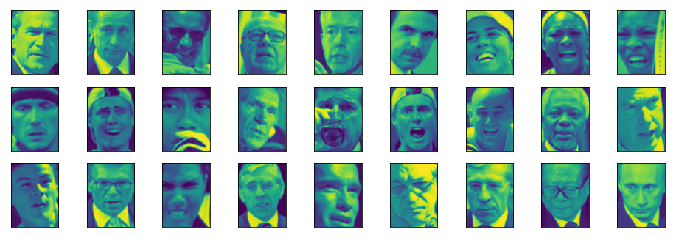

In [10]:
noise = X_people[labels==-1]

fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
plt.show()

将这些图像与`图3-7`中随机选择的人脸图像样本进行比较，我们可以猜测它们被标记为噪声的原因：第2行第5张图像显示一个人正在用玻璃杯喝水，还有人戴帽子的图像，第2行第5张图像中，人脸前面有一只手。其他图像都包含奇怪的角度，或者太近或太宽的剪切。

这种类型的分析——尝试找出“奇怪的那一个”——被称为`异常值检测(outlier detection)`。如果这是一个真实的应用，那么我们可能会尝试更好地裁切图像，以得到更加均匀的数据。对于照片中的人有时戴着帽子、喝水或在面前举着某物，我们能做的事情很少。但需要知道它们是数据中存在的问题，我们应用任何算法都需要解决这些问题。

如果我们想要找到更有趣的簇，而不是一个非常大的簇，那么需要将`eps`设置得更小，取值在15和0.5(默认值)之间。我们来看一下`eps`不同取值对应的结果：

In [11]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("eps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("   Clusters present: {}".format(np.unique(labels)))
    print("   Cluster sizes: {}".format(np.bincount(labels + 1)))

eps=1
   Clusters present: [-1]
   Cluster sizes: [2063]
eps=3
   Clusters present: [-1]
   Cluster sizes: [2063]
eps=5
   Clusters present: [-1]
   Cluster sizes: [2063]
eps=7
   Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
   Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]
eps=9
   Clusters present: [-1  0  1  2]
   Cluster sizes: [1307  750    3    3]
eps=11
   Clusters present: [-1  0]
   Cluster sizes: [ 413 1650]
eps=13
   Clusters present: [-1  0]
   Cluster sizes: [ 120 1943]


对于较小的`eps`，所有点都被标记为噪声；`eps=7`时，我们得到许多噪声点和许多较小的簇；`eps=9`时，我们仍得到许多噪声点，但我们得到了一个较大的簇和一些较小的簇；从`eps=11`开始，我们仅得到一个较大的簇和噪声。

有趣的是，较大的簇从来没有超过一个。最多有一个较大的簇包含大多数点，还有一些较小的簇。这表示数据中没有两类或三类非常不同的人脸图像，而是所有图像或多或少地都与其他图像具有相同的相似度（或不相似度）。

`eps=7`的结果看起来最有趣，它有许多较小的簇。我们可以通过将13个较小的簇中的点全部可视化来深入研究这一聚类(`图3-42`)：

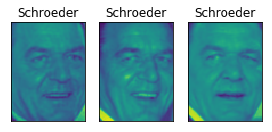

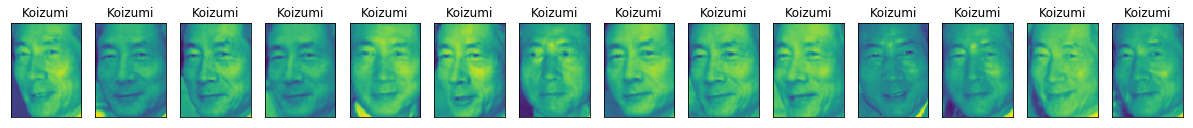

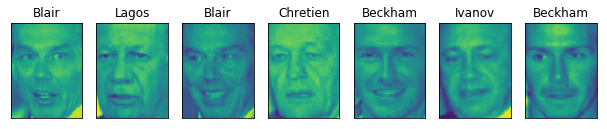

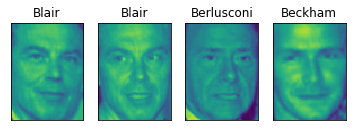

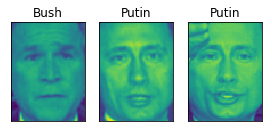

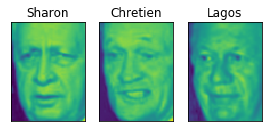

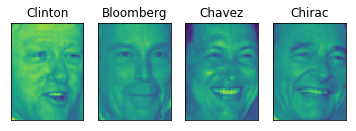

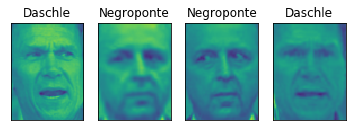

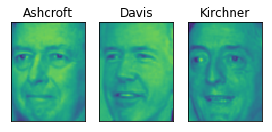

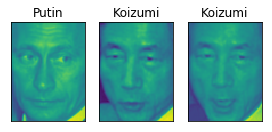

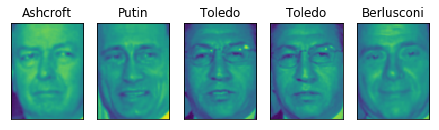

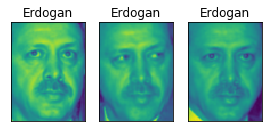

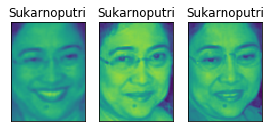

In [12]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4), subplot_kw={'xticks':(), 'yticks':()})
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])
plt.show()

有一些簇对应于(这个数据集中)脸部非常不同的人，比如`Sharon`或`Koizumi`。在每个簇内，人脸方向和面部表情也是固定的。有些簇中包含多个人的面孔，但他们的方向和表情都相似。

*这就是我们将DBSCAN算法应用于人脸数据集的分析结论。不同于监督学习中基于$R^2$分数或精度的更为自动化的搜索方法，我们进行了人工分析。*

**用kMeans分析人脸数据集**
利用DBSCAN无法创建多于一个较大的簇。凝聚聚类和kMeans更可能创建均匀大小的簇，但我们需要设置簇的目标个数。我们可以将簇的数量设置为数据集中的已知人数，虽然无监督聚类算法不太可能完全找到它们。相反，我们可以首先设置一个比较小的簇的数量，比如10个，这样我们可以分析每个簇：

In [13]:
# 用k均值提取簇
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [155 175 238  75 358 257  91 219 323 172]


数据被划分为大小相似的簇，这与DBSCAN的结果非常不同。

我们可以通过将簇中心可视化来进一步分析kMeans的结果(`图3-43`)。由于我们是在PCA生成的表示中进行聚类，因此我们需要使用`pca.inverse_transform`将簇中心旋转回到原始空间并可视化：

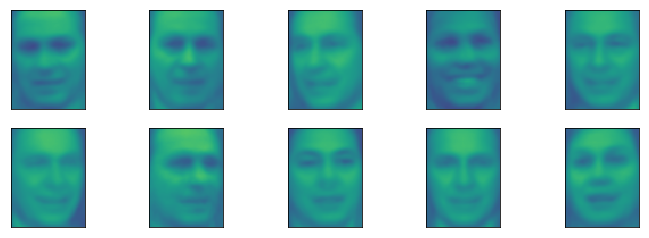

In [14]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape),
              vmin=0, vmax=1)
plt.show()

kMeans找到的簇中心是非常平滑的人脸。这并不奇怪，因为每个簇中心都是多张人脸图像的平均。使用降维的PCA表示，可以增加图像的平滑度(对比`图3-11`中利用100个PCA维度重建的人脸)。聚类似乎捕捉到人脸的不同方向、不同表情(第4个簇中心似乎显示的是一张笑脸)，以及是否有衬衫领子(见倒数第二个簇中心)。

`图3-44`给出了更详细的视图，我们对每个簇中心给出了簇中5张最典型的图像(该簇中与簇中心距离最近的图像)与5张最不典型的图像(该簇中与簇中心距离最远的图像)：

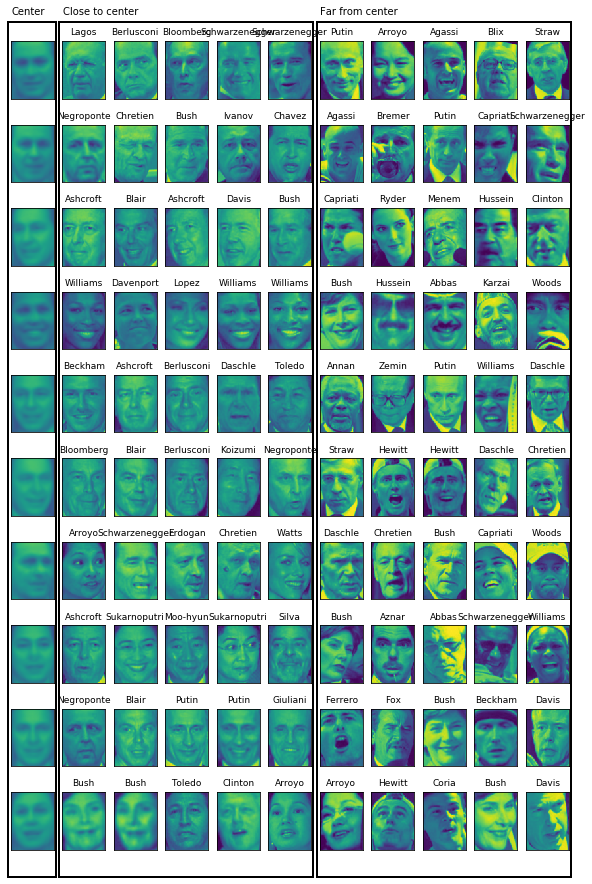

In [15]:
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people, y_people, people.target_names)
plt.show()

`图3-44`证实了我们认为第4个簇是笑脸的直觉，也证实了其他簇中方向的重要性。不过“非典型的”点与簇中心不太相似，而且它们的分配似乎有些随意。这可以归因于以下事实：kMeans对所有数据点进行划分，不像DBSCAN那样具有“噪声”点的概念。利用更多数量的簇，算法可以找到更细微的区别。但添加更多的簇会使得人工检查更加困难。

**用凝聚聚类分析人脸数据集**
下面我们来看一下凝聚聚类的结果：

In [16]:
# 用ward凝聚聚类提取簇
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print("Cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

Cluster sizes agglomerative clustering: [169 660 144 329 217  85  18 261  31 149]


凝聚聚类生成的也是大小相近的簇，比kMeans生成的簇更不均匀，但比DBSCAN生成的簇要均匀。

我们可以通过计算ARI来度量凝聚聚类和kMeans给出的两种数据划分是否相似：

In [17]:
print("ARI: {:.2f}".format(adjusted_rand_score(labels_agg, labels_km)))

ARI: 0.09


ARI只有$0.09$，说明`labels_agg`和`labels_km`这两种聚类的共同点很少。这并不奇怪，原因在于以下事实：对于kMeans，远离簇中心的点似乎没有什么共同点。

下面，我们可能会想要绘制树状图(`图3-45`)。我们将限制图中树的深度，因为如果分支到2063个数据点，图像将密密麻麻无法阅读：

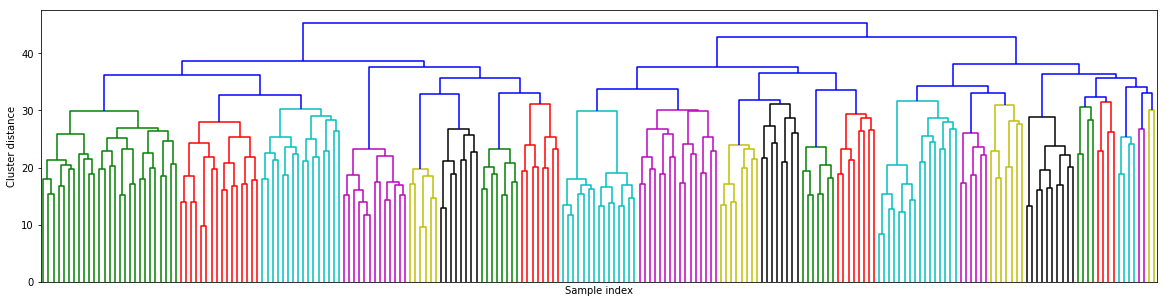

In [18]:
linkage_array = ward(X_pca)
# 现在我们为包含簇之间距离的linkage_array绘制树状图
plt.figure(figsize=(20, 5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

要想创建10个簇，我们在顶部有10条竖线的位置将树横切。在`图3-36`所示的玩具数据的树状图中，你可以从分支的长度中看出，两个或三个簇就可以很好地划分数据。对于人脸数据而言，似乎没有非常自然的切割点。有一些分支代表更为不同的组，但似乎没有一个特别合适的簇的数量。这并不奇怪，因为DBSCAN的结果是试图将所有的点都聚类在一起。

我们将10个簇可视化，正如之前对kMeans所做的那样(`图3-46`)。请注意，在凝聚聚类中没有簇中心的概念（虽然我们计算平均值），我们只是给出了每个簇的前几个点。我们在第一张图像的左侧给出了每个簇中的点的数量：

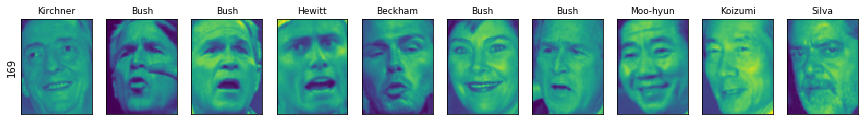

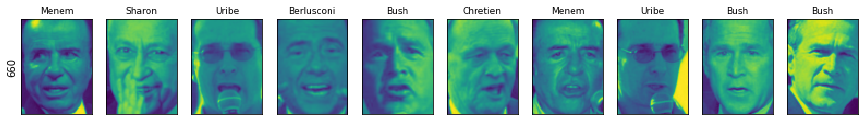

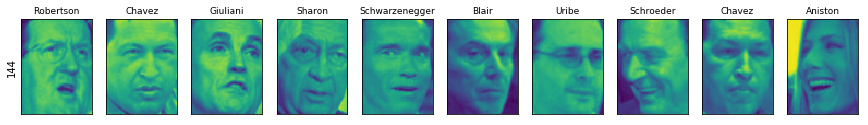

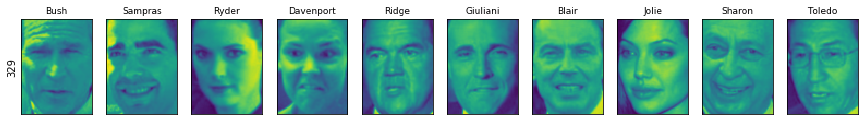

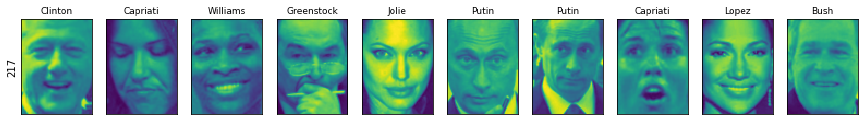

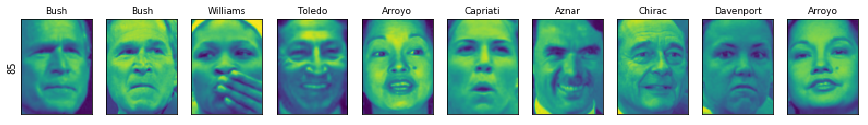

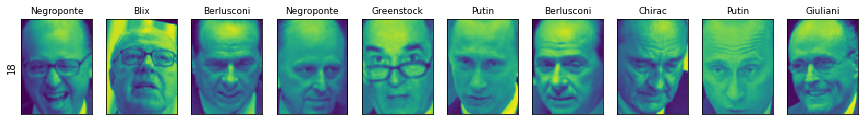

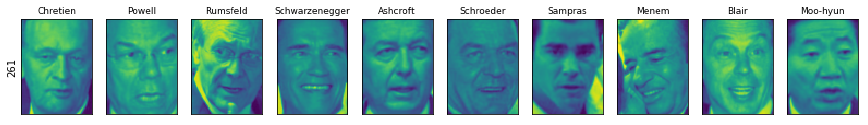

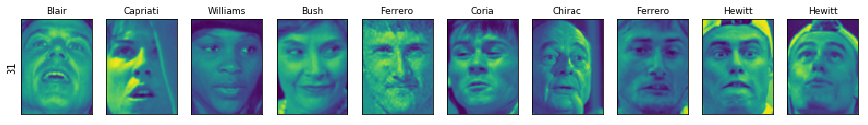

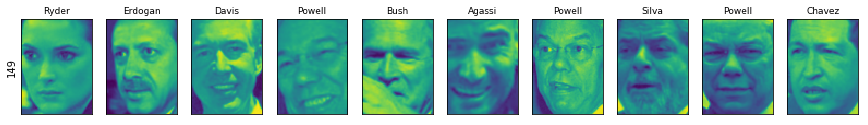

In [19]:
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})
plt.show()

虽然某些簇似乎具有语义上的主题，但许多簇都太大而实际上很难是均匀的。为了得到更加均匀的簇，我们可以再次运行算法，这次使用40个簇，并挑选出一些特别有趣的簇(`图3-47`)：

cluster sizes agglomerative clustering: [ 43 120 100 194  56  58 127  22   6  37  65  49  84  18 168  44  47  31
  78  30 166  20  57  14  11  29  23   5   8  84  67  30  57  16  22  12
  29   2  26   8]


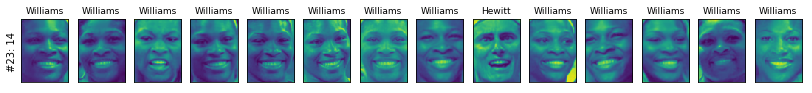

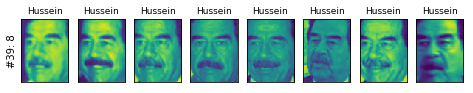

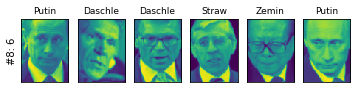

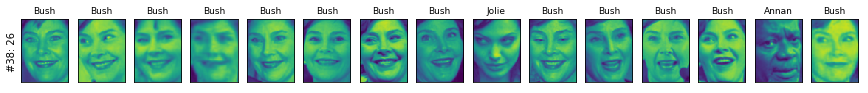

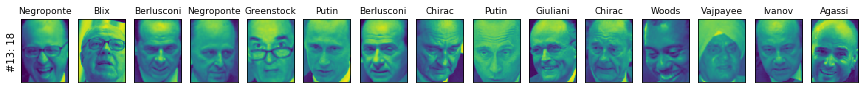

In [20]:
# 用ward凝聚聚类提取簇
agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

n_clusters = 40
for cluster in [23, 39, 8, 38, 13]: # 手动挑选“有趣的”簇
# for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})
    for i in range(cluster_size, 15):
        axes[i].set_visible(False)
plt.show()

这里聚类挑选出的似乎是“深色皮肤且微笑”“萨达姆”“有领子的衬衫”“微笑的女性”和“高额头”。如果进一步详细分析，我们还可以利用树状图找到这些高度相似的簇。

### 3.5.5 聚类方法小结
本节的内容表明，聚类的应用与评估是一个非常定性的过程，通常在数据分析的探索阶段很有帮助。我们学习了三种聚类算法：kMeans、DBSCAN和凝聚聚类。这三种算法都可以控制聚类的粒度。kMeans和凝聚聚类允许你指定想要的簇的数量，而DBSCAN允许你用`eps参数`定义接近程度，从而间接影响簇的大小。三种方法都可以用于大型的现实世界数据集，都相对容易理解，也都可以聚类成多个簇。

每种算法的优点稍有不同。kMeans可以用簇的平均值来表示簇。它还可以被看作一种分解方法，每个数据点都由其簇中心表示。DBSCAN可以检测到没有分配任何簇的“噪声点”，还可以帮助自动判断簇的数量。与其他两种方法不同，它允许簇具有复杂的形状，正如我们在`two_moons`的例子中所看到的那样。DBSCAN有时会生成大小差别很大的簇，这可能是它的优点，也可能是缺点。凝聚聚类可以提供数据的可能划分的整个层次结构，可以通过树状图轻松查看。

分解、流形学习和聚类都是加深数据理解的重要工具，在没有监督信息的情况下，也是理解数据的仅有的方法。即使是在监督学习中，探索性工具对于更好地理解数据性质也很重要。通常来说，很难量化无监督算法的有用性，但这不应该妨碍你使用它们来深入理解数据。学完这些方法，你就已经掌握了机器学习从业者每天使用的所有必要的学习算法。

我们建议你在`scikit-learn`中包含的二维玩具数据和现实世界数据集(比如`digits、iris和cancer数据集`)上尝试聚类和分解方法。